In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the dataset an viewing the first few rows
df = pd.read_csv('cleaned_titanic_df.txt')
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,...,title,male,cabin_deck,Embarked_s,Embarked_q,Embarked_c,family_size,is_alone,is_child,is_senior
0,0,1,0,3,male,22.0,1,0,7.2500,NaN,...,Mr,1,6,1,0,0,2,0,0,0
1,1,2,1,1,female,38.0,1,0,71.2833,C85,...,Mrs,0,3,0,0,1,2,0,0,0
2,2,3,1,3,female,26.0,0,0,7.9250,NaN,...,Miss,0,6,1,0,0,1,1,0,0
3,3,4,1,1,female,35.0,1,0,53.1000,C123,...,Mrs,0,3,1,0,0,2,0,0,0
4,4,5,0,3,male,35.0,0,0,8.0500,NaN,...,Mr,1,6,1,0,0,1,1,0,0


In [3]:
# Dropping unwanted columns
df = df.drop(columns=['Unnamed: 0', 'Pclass', 'Sex', 'Cabin', 'Embarked'])

# Checking Random Forest Assumptions

In [4]:
# Checking that all observations are independent
df.PassengerId.nunique() == df.PassengerId.count()

True

In [5]:
# One hot encoding categorical columns
dummy_df = pd.get_dummies(df, columns=['title'], dtype='int64', drop_first=False)

In [6]:
# Checking all features are relevant
correlation_matrix = dummy_df.corr()
print(correlation_matrix['Survived'])

PassengerId    -0.014291
Survived        1.000000
Age            -0.083736
SibSp          -0.040547
Parch           0.080408
Fare            0.298671
Pclass_1        0.273441
Pclass_2        0.102802
Pclass_3       -0.314873
male           -0.534088
cabin_deck     -0.252189
Embarked_s     -0.140553
Embarked_q      0.008376
Embarked_c      0.156060
family_size     0.011916
is_alone       -0.201893
is_child        0.124812
is_senior      -0.009583
title_Capt     -0.026350
title_Dr        0.009659
title_Master    0.089846
title_Miss      0.325910
title_Mr       -0.541600
title_Mrs       0.347907
title_Rev      -0.064730
Name: Survived, dtype: float64


In [7]:
# Checking how many samples and features there are
dummy_df.shape

(871, 25)

In [8]:
# Checking the counts for each value in the outcome variable
dummy_df.Survived.value_counts()

Survived
0    543
1    328
Name: count, dtype: int64

In [9]:
# Calculating the outcome class positivity rate
positivity_rate = 328/len(dummy_df)
print(positivity_rate)
# We can see that the outcome class is not balanced, this will be sorted later.

0.37657864523536166


In [10]:
# Creating two new variables, one for the features and one for the outcome 
x = dummy_df.drop(columns=['PassengerId', 'Survived'])
y = dummy_df[['Survived']]

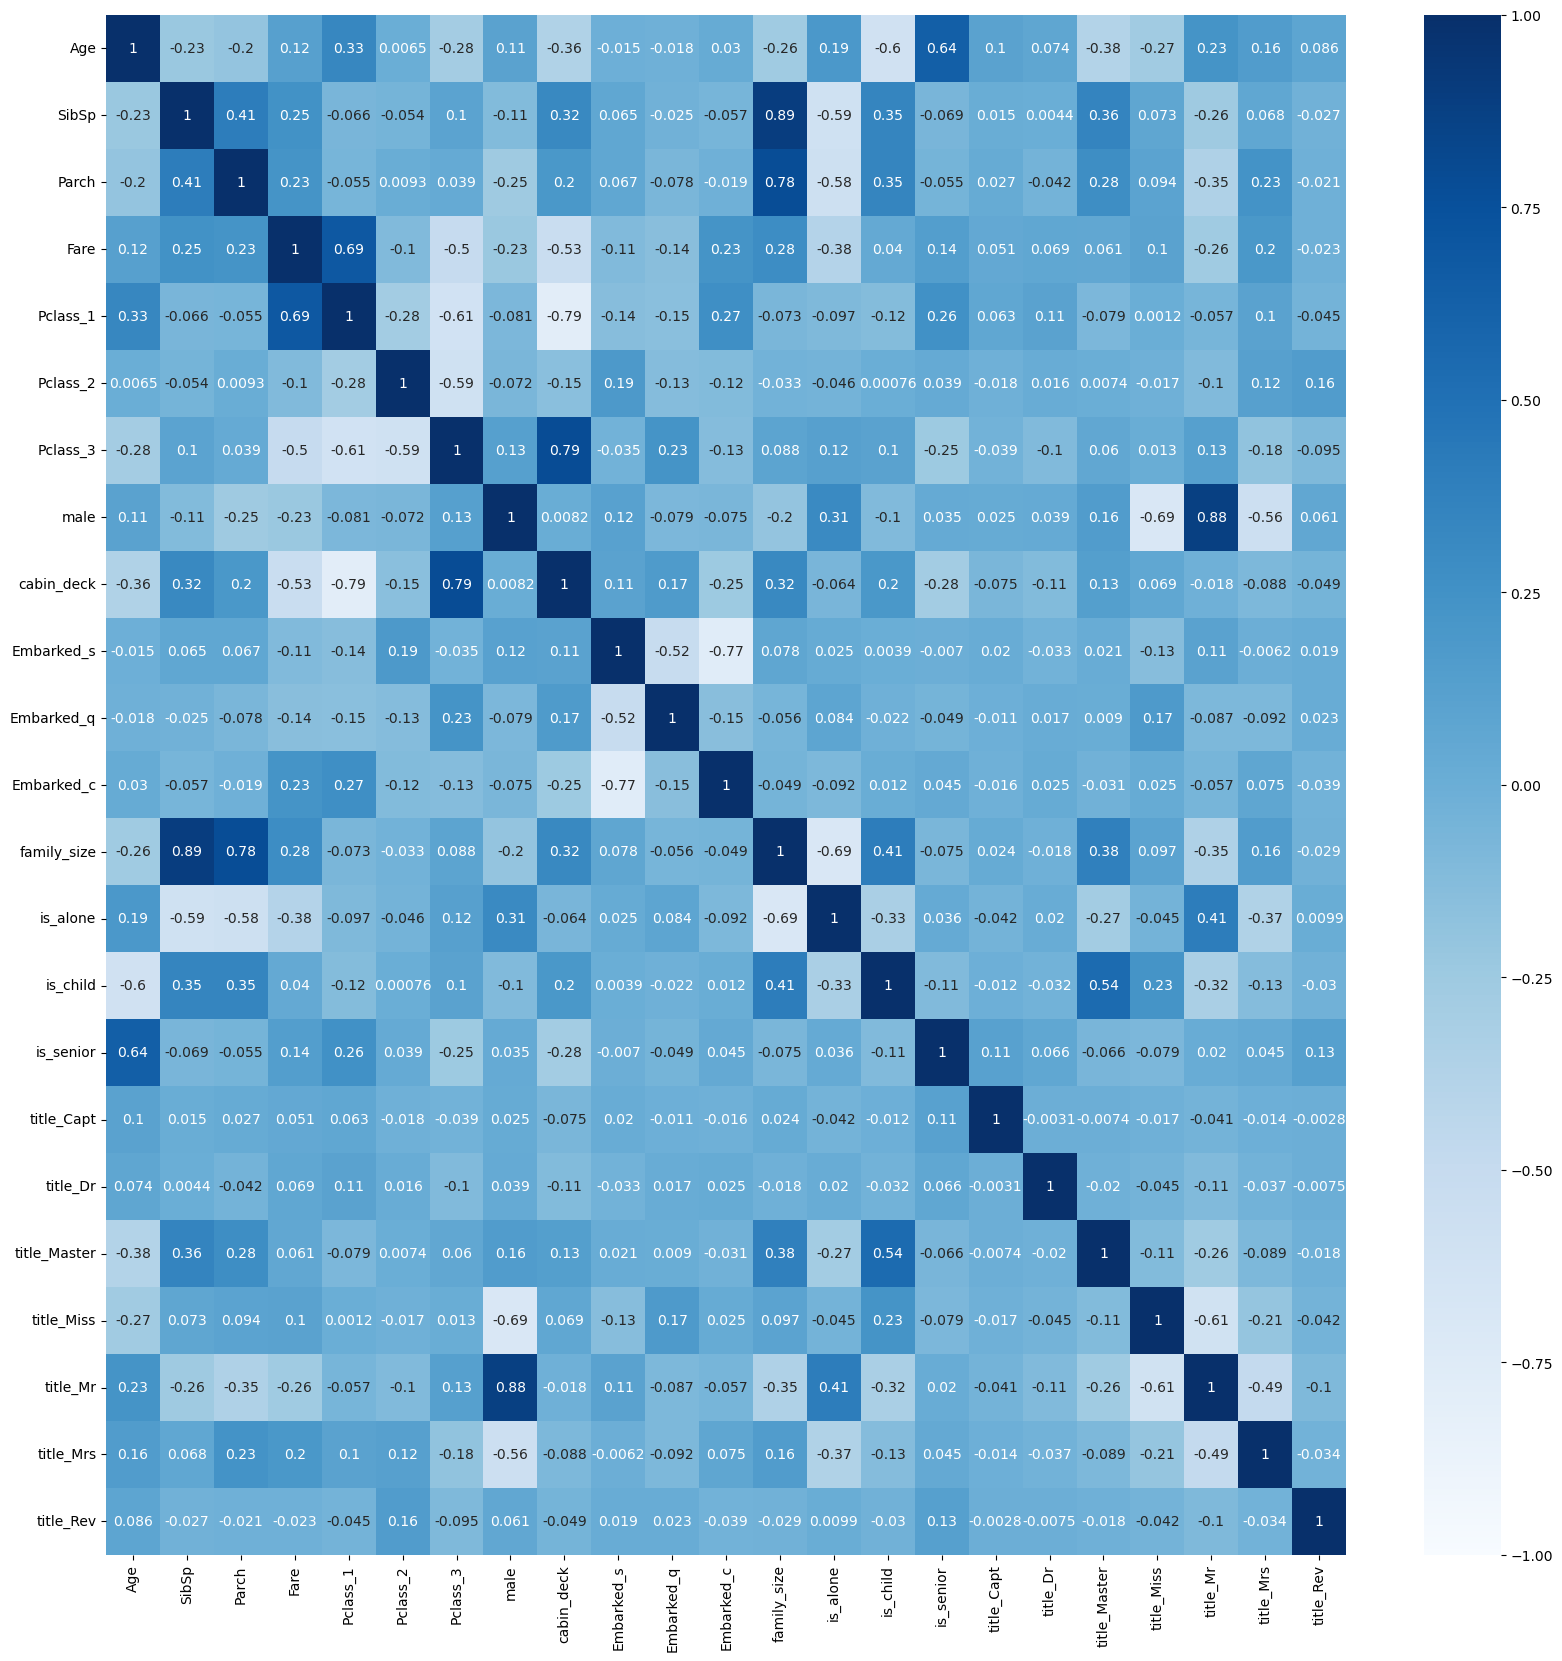

In [11]:
# Visualising the correlation between each feature to check for multicollinearity
plt.figure(figsize=(20,20))
sns.heatmap(x.corr(), annot=True, vmin=-1, center=0, vmax=1, cmap='Blues')
plt.show()

In [12]:
# Removing features with a high correlation as they are likely to be redundent
x = x.drop(columns=['family_size', 'title_Mr', 'Embarked_c', 'cabin_deck'])

# Best Train Test Split

In [13]:
# Function to train and evaluate a logistic regression model
def best_random_state(state):
    
    # Train Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=state, stratify=y)   
    
    # Applying SMOTE to balance the training set
    sm = SMOTE(random_state=1, sampling_strategy= 'minority')
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
      
    # Initialize and train the logistic regression model
    model = RandomForestClassifier(max_depth=5, n_estimators=100, bootstrap=True, random_state=1, n_jobs=-1)
    model.fit(x_train_res, y_train_res)
    
    # Evaluate the model and return the accuracy
    accuracy = model.score(x_test, y_test)
    return accuracy

In [14]:
# Creating an empty list to hold all the accuracies from different random states
acc = []

# Performing the function for 100 different random states and adding the accuracies to the list
for k in range(1,101):
    acc.append(best_random_state(k))

In [15]:
# Creating a list of the random state potential numbers
random_state_list = range(1,101)

# Finding the index of the max value in the list
best_split_index = acc.index(max(acc))

# Using the index to find the best train test split
best_split = random_state_list[best_split_index]
best_split

2

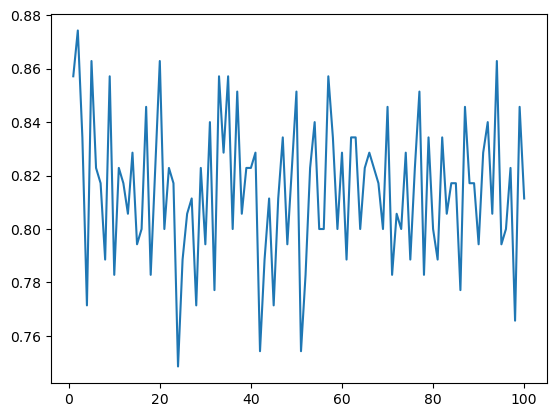

In [16]:
# Visualising the test scores associated with each random state value
plt.plot(random_state_list, acc)
plt.show()

# Best Random State SMOTE

In [17]:
# Function to train and evaluate a logistic regression model
def best_smote_random_state(state):
    
    # Train Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=best_split, stratify=y)   
    
    # Applying SMOTE to balance the training set
    sm = SMOTE(random_state=state, sampling_strategy= 'minority')
    x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
    
    # Initialize and train the logistic regression model
    model = RandomForestClassifier(max_depth=5, n_estimators=100, bootstrap=True, random_state=1, n_jobs=-1)
    model.fit(x_train_res, y_train_res)
    
    # Evaluate the model and return the accuracy
    accuracy = model.score(x_test, y_test)
    return accuracy

In [18]:
# Creating an empty list to hold all the accuracies from different random states
smote_acc = []

# Performing the function for 100 different random states and adding the accuracies to the list
for k in range(1,101):
    smote_acc.append(best_smote_random_state(k))

In [19]:
# Finding the index of the max value in the list
best_smote_split_index = smote_acc.index(max(smote_acc))

# Using the index to find the best train test split
best_smote_split = random_state_list[best_smote_split_index]
best_smote_split

16

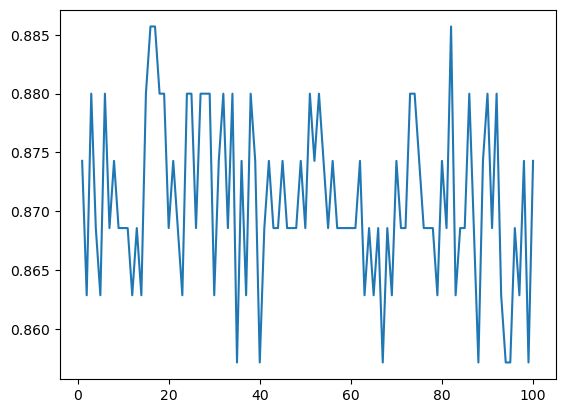

In [20]:
# Visualising the test scores associated with each random state value
plt.plot(random_state_list, smote_acc)
plt.show()

# Train Test Split

In [21]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=best_split, stratify=y)

# SMOTE

In [22]:
# Checking the value counts for the outcome variable in the training data
print(y_train.value_counts())

Survived
0           434
1           262
Name: count, dtype: int64


In [23]:
# Creating a SMOTE model to balance out the outcome variable values
sm = SMOTE(random_state=best_smote_split, sampling_strategy='minority')

# Applying the smote sampler to the training data
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

# Checking the value counts for the outcome variable in the training data
print(y_train_res.value_counts())

Survived
0           434
1           434
Name: count, dtype: int64


# Random Forest Classifier

In [24]:
# Creating a random forest classifier
classifier = RandomForestClassifier(max_depth=5, n_estimators=100, bootstrap=True, random_state=1, n_jobs=-1)
classifier.fit(x_train_res, y_train_res)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

In [25]:
# Finding the scores for the training and testing data
print('Train score')
print(classifier.score(x_train_res, y_train_res))
print('Test score')
print(classifier.score(x_test, y_test))

Train score
0.8663594470046083
Test score
0.8857142857142857


In [26]:
# Getting the prediction on the training and test data
y_pred_train = classifier.predict(x_train_res)
y_pred_test = classifier.predict(x_test)

In [27]:
# Getting the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy score is ' + str(accuracy))

# Getting the precision score of the model on the testing data
precision = precision_score(y_test, y_pred_test)
print('Precision score is ' + str(precision))

# Getting the recall score of the model on the testing data
recall = recall_score(y_test, y_pred_test)
print('Recall score is ' + str(recall))

# Getting the f1 score of the model on the testing data
f1 = f1_score(y_test, y_pred_test)
print('F1 score is ' + str(f1))

Accuracy score is 0.8857142857142857
Precision score is 0.896551724137931
Recall score is 0.7878787878787878
F1 score is 0.8387096774193549


In [28]:
# Getting the train and test mse
train_mse = mean_squared_error(y_train_res, y_pred_train)
print('Train MSE '+ str(train_mse))
test_mse = mean_squared_error(y_test, y_pred_test)
print('Test MSE ' + str(test_mse))

Train MSE 0.1336405529953917
Test MSE 0.11428571428571428


In [29]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index=['Died', 'Survived'], 
                                     columns=['Predicted Dead', 'Predicted Survived'])
test_confusion_matrix

,Predicted Dead,Predicted Survived
Died,103,6
Survived,14,52


In [30]:
# Checking the feature importance
importances = classifier.feature_importances_

for i, importance in enumerate(importances):
    print(f"Feature {x_train.columns[i]}: {importance}")

Feature Age: 0.06576385159251637
Feature SibSp: 0.0294736029555198
Feature Parch: 0.017067918723321376
Feature Fare: 0.1309074593320203
Feature Pclass_1: 0.0389548353886522
Feature Pclass_2: 0.018231907440814855
Feature Pclass_3: 0.12051038158573997
Feature male: 0.3779445367479646
Feature Embarked_s: 0.038617023453538527
Feature Embarked_q: 0.006248718942577684
Feature is_alone: 0.03193290134551244
Feature is_child: 0.009789823323054957
Feature is_senior: 0.006831623339259213
Feature title_Capt: 0.0006500299810325821
Feature title_Dr: 0.00043471295340734105
Feature title_Master: 0.014377800870425773
Feature title_Miss: 0.054598740074603816
Feature title_Mrs: 0.0356933064136775
Feature title_Rev: 0.0019708255363605856


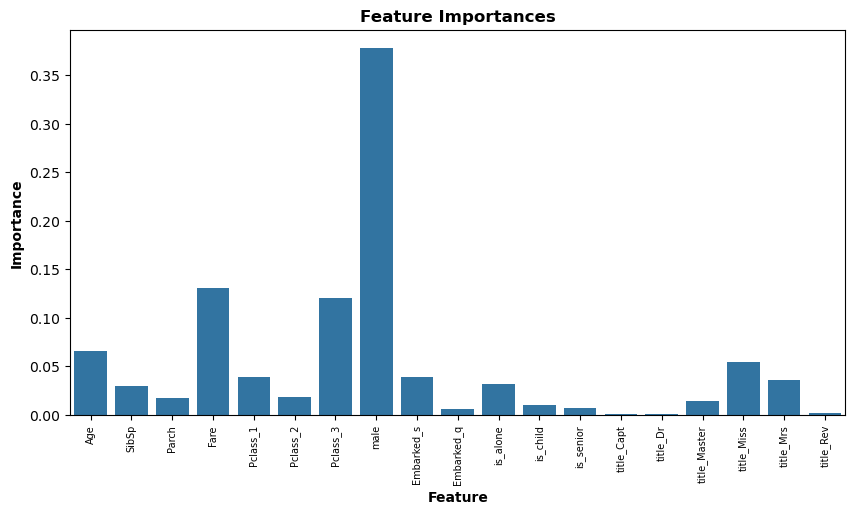

In [31]:
# Visualising the importances of each feature
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.barplot(importances)
ax.set_xticklabels(x_train.columns)
plt.xticks(rotation=90, size=7)
plt.title('Feature Importances', weight='bold')
plt.xlabel('Feature', weight='bold')
plt.ylabel('Importance', weight='bold')
plt.show()

# Feature selection

In [32]:
# Finding the features that have a high importance. Greater than 0.025
important_features = [feature for feature, importance in zip(x_train.columns, importances) if importance > 0.025]

In [33]:
# Transforming the x train_res and x test data to just include the features selected
x_train_trans = x_train_res[important_features]
x_test_trans = x_test[important_features]

# Random Forest Classifier #2

In [34]:
# Creating a new classifier 
classifier_2 = RandomForestClassifier(max_depth=5, n_estimators=100, bootstrap=True, random_state=1, n_jobs=-1)

# Fitting the classifier with the subset of features
classifier_2.fit(x_train_trans, y_train_res)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

In [35]:
# Calculating the score on the train and test data
print('Train score')
print(classifier_2.score(x_train_trans, y_train_res))
print('Test score')
print(classifier_2.score(x_test_trans, y_test))

Train score
0.868663594470046
Test score
0.8685714285714285


In [36]:
# Getting the prediction on the training and test data
y_pred_train_2 = classifier_2.predict(x_train_trans)
y_pred_test_2 = classifier_2.predict(x_test_trans)

In [37]:
# Getting the accuracy score of the model on the testing data
accuracy_2 = accuracy_score(y_test, y_pred_test_2)
print('Accuracy score is ' + str(accuracy_2))

# Getting the precision score of the model on the testing data
precision_2 = precision_score(y_test, y_pred_test_2)
print('Precision score is ' + str(precision_2))

# Getting the recall score of the model on the testing data
recall_2 = recall_score(y_test, y_pred_test_2)
print('Recall score is ' + str(recall_2))

# Getting the f1 score of the model on the testing data
f1_2 = f1_score(y_test, y_pred_test_2)
print('F1 score is ' + str(f1_2))

Accuracy score is 0.8685714285714285
Precision score is 0.8771929824561403
Recall score is 0.7575757575757576
F1 score is 0.8130081300813008


In [38]:
# Getting the train and test mse
train_mse_2 = mean_squared_error(y_train_res, y_pred_train_2)
print('Train MSE '+ str(train_mse_2))
test_mse_2 = mean_squared_error(y_test, y_pred_test_2)
print('Test MSE ' + str(test_mse_2))

Train MSE 0.1313364055299539
Test MSE 0.13142857142857142


In [39]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix_2 = pd.DataFrame(confusion_matrix(y_test, y_pred_test_2), index=['Died', 'Survived'], 
                                     columns=['Predicted Dead', 'Predicted Survived'])
test_confusion_matrix_2

,Predicted Dead,Predicted Survived
Died,102,7
Survived,16,50


In [40]:
# Checking the feature importance of the final model
importances_2 = classifier_2.feature_importances_

for i, importance in enumerate(importances_2):
    print(f"Feature {x_train_trans.columns[i]}: {importance}")

Feature Age: 0.0939113423190917
Feature SibSp: 0.03875544534114358
Feature Fare: 0.15501139765224423
Feature Pclass_1: 0.03621406819526331
Feature Pclass_3: 0.10464438473881513
Feature male: 0.4216414587375569
Feature Embarked_s: 0.03994190409120191
Feature is_alone: 0.028197656970332736
Feature title_Miss: 0.04925761363077554
Feature title_Mrs: 0.032424728323575056


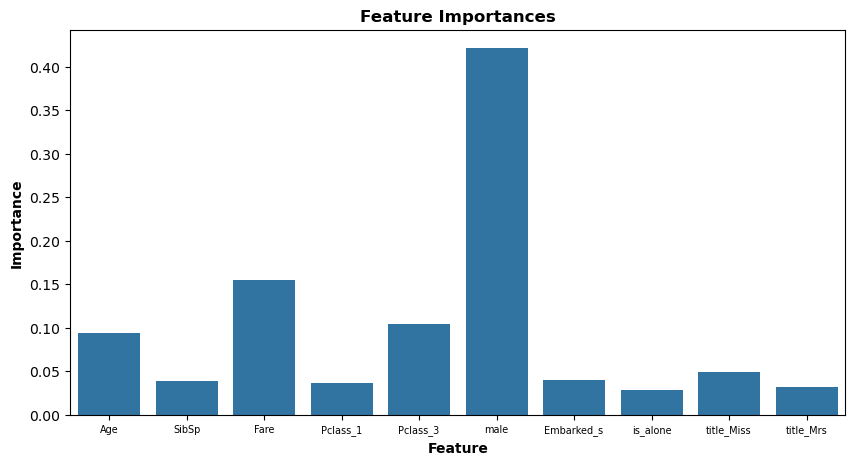

In [41]:
# Visualising the importances of each feature for the final classifier
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.barplot(importances_2)
ax.set_xticklabels(x_train_trans.columns)
plt.xticks(size=7)
plt.title('Feature Importances', weight='bold')
plt.xlabel('Feature', weight='bold')
plt.ylabel('Importance', weight='bold')
plt.show()

# Hyperparameter tuning

In [42]:
# Creating a dictionary of all the hyperparameters to tune
param_grid = {'max_features':['auto', 'sqrt'], 'max_depth':[3,5,7], 'n_estimators':[100, 200], 
              'min_samples_split':[1,2,5], 'min_samples_leaf':[1,2,5]}

# Creating a gridsearchcv model
grid_search = GridSearchCV(classifier_2, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fitting the model to the training data
grid_search.fit(x_train_trans, y_train_res)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, n_jobs=-1,
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [1, 2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [43]:
# Checking the best parameter combination and cross validated score on the training data
print('Best params ' + str(grid_search.best_params_))
print('Best score ' + str(grid_search.best_score_))

Best params {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score 0.8376918477177597


# Final Random Forest Classifier

In [44]:
# Creating a final classifier with the tuned parameters
final_classifier = RandomForestClassifier(bootstrap=True, 
                                          max_depth=grid_search.best_params_['max_depth'],
                                          max_features=grid_search.best_params_['max_features'],
                                          min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
                                          min_samples_split=grid_search.best_params_['min_samples_split'], 
                                          n_estimators=grid_search.best_params_['n_estimators'], 
                                          random_state=1, n_jobs=-1)

# Fitting the classifier to the training data
final_classifier.fit(x_train_trans, y_train_res)

RandomForestClassifier(max_depth=7, min_samples_split=5, n_jobs=-1,
                       random_state=1)

# Evaluating final classifier

In [45]:
# Checking the score on the training and test data
print('Train score')
print(final_classifier.score(x_train_trans, y_train_res))

print('Test score')
print(final_classifier.score(x_test_trans, y_test))

Train score
0.8940092165898618
Test score
0.8742857142857143


In [46]:
# Getting the prediction on the training and test data
y_pred_train_3 = final_classifier.predict(x_train_trans)
y_pred_test_3 = final_classifier.predict(x_test_trans)

In [47]:
# Getting the accuracy score of the model on the testing data
accuracy_3 = accuracy_score(y_test, y_pred_test_3)
print('Accuracy score is ' + str(accuracy_3))

# Getting the precision score of the model on the testing data
precision_3 = precision_score(y_test, y_pred_test_3)
print('Precision score is ' + str(precision_3))

# Getting the recall score of the model on the testing data
recall_3 = recall_score(y_test, y_pred_test_3)
print('Recall score is ' + str(recall_3))

# Getting the f1 score of the model on the testing data
f1_3 = f1_score(y_test, y_pred_test_3)
print('F1 score is ' + str(f1_3))

Accuracy score is 0.8742857142857143
Precision score is 0.8928571428571429
Recall score is 0.7575757575757576
F1 score is 0.819672131147541


In [48]:
# Getting the train and test mse
train_mse_3 = mean_squared_error(y_train_res, y_pred_train_3)
print('Train MSE '+ str(train_mse_3))
test_mse_3 = mean_squared_error(y_test, y_pred_test_3)
print('Test MSE ' + str(test_mse_3))

Train MSE 0.10599078341013825
Test MSE 0.12571428571428572


In [49]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix_3 = pd.DataFrame(confusion_matrix(y_test, y_pred_test_3), index=['Died', 'Survived'], 
                                     columns=['Predicted Dead', 'Predicted Survived'])
test_confusion_matrix_3

,Predicted Dead,Predicted Survived
Died,103,6
Survived,16,50


In [50]:
# Checking the feature importance of the final model
importances_3 = final_classifier.feature_importances_

for i, importance in enumerate(importances_3):
    print(f"Feature {x_train_trans.columns[i]}: {importance}")

Feature Age: 0.13030993051366044
Feature SibSp: 0.04027729623413441
Feature Fare: 0.18800770499115285
Feature Pclass_1: 0.035889391915115115
Feature Pclass_3: 0.09069843135559534
Feature male: 0.3733771365073221
Feature Embarked_s: 0.04034945214520744
Feature is_alone: 0.02628645861655316
Feature title_Miss: 0.04601568603912924
Feature title_Mrs: 0.028788511682129928


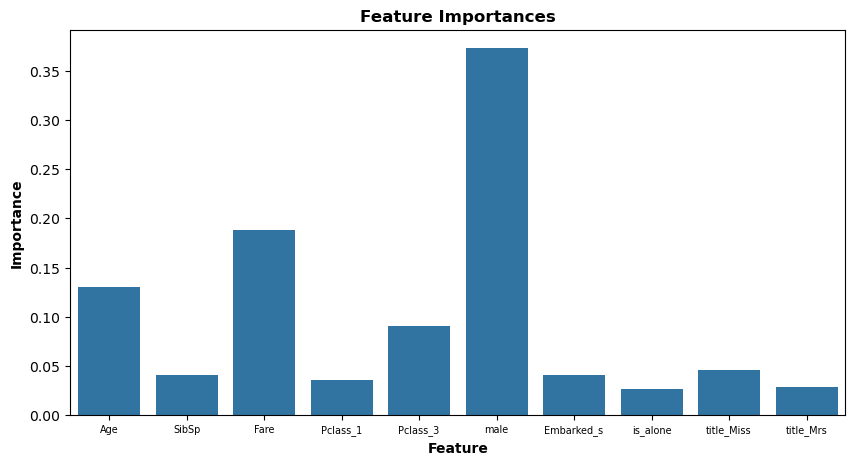

In [51]:
# Visualising the importances of each feature for the final classifier
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.barplot(importances_3)
ax.set_xticklabels(x_train_trans.columns)
plt.xticks(size=7)
plt.title('Feature Importances', weight='bold')
plt.xlabel('Feature', weight='bold')
plt.ylabel('Importance', weight='bold')
plt.savefig('rf_feature_importances.png')
plt.show()

# ROC Score & Thresholds

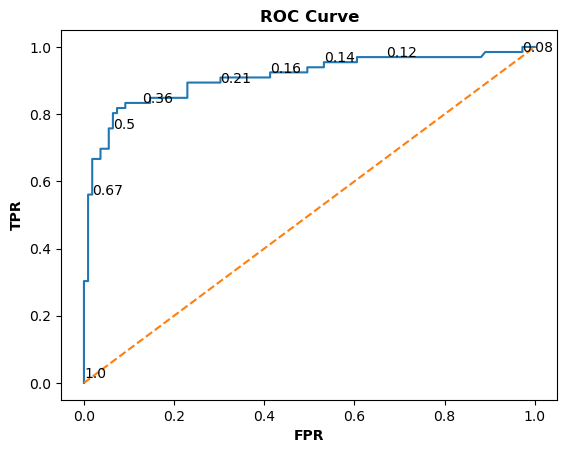

In [52]:
# Getting the probabilities of each outcome for the test set from the tuned model
y_pred_prob_test = final_classifier.predict_proba(x_test_trans)

# Getting the true positive rate and false postive rate from the testing set
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_test[:,1])

# Visualing the fpr and tpr 
plt.plot(fpr, tpr)
idx = list(range(len(threshold)))[1::6]
for i in idx:
    plt.text(fpr[i], tpr[i], threshold[i].round(2))
    
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train_trans, y_train_res)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test_trans)[:,1])

clf_fpr, clf_tpr, clf_threshold = roc_curve(y_test, clf.predict_proba(x_test_trans)[:,1])
plt.plot(clf_fpr, clf_tpr, linestyle='--')

plt.title('ROC Curve', weight='bold')
plt.xlabel('FPR', weight='bold')
plt.ylabel('TPR', weight='bold')
plt.savefig('rf_roc_curve.png')
plt.show()

In [53]:
# Finding the roc auc score
roc_auc_score_ = roc_auc_score(y_test, y_pred_prob_test[:,1])
roc_auc_score_

0.9094384209063109

In [54]:
# Finding the best threshold youlden stat, highest tpr
j_scores = tpr - fpr

# Youlden's J statistic
youlden_threshold = threshold[np.argmax(j_scores)]
print(youlden_threshold)

0.43902532346884127


In [55]:
# Creating a confusion matrix for youlden threshold
y_pred_youlden = (y_pred_prob_test[:,1] > youlden_threshold)*1.0
cm_youlden = confusion_matrix(y_test, y_pred_youlden)
print(cm_youlden)

[[101   8]
 [ 13  53]]


In [56]:
# Getting the accuracy score for the model at the best threshold
accuracy_youlden = accuracy_score(y_test, y_pred_youlden)
print('Accuracy score is ' + str(accuracy_youlden))

Accuracy score is 0.88


# Learning Curve

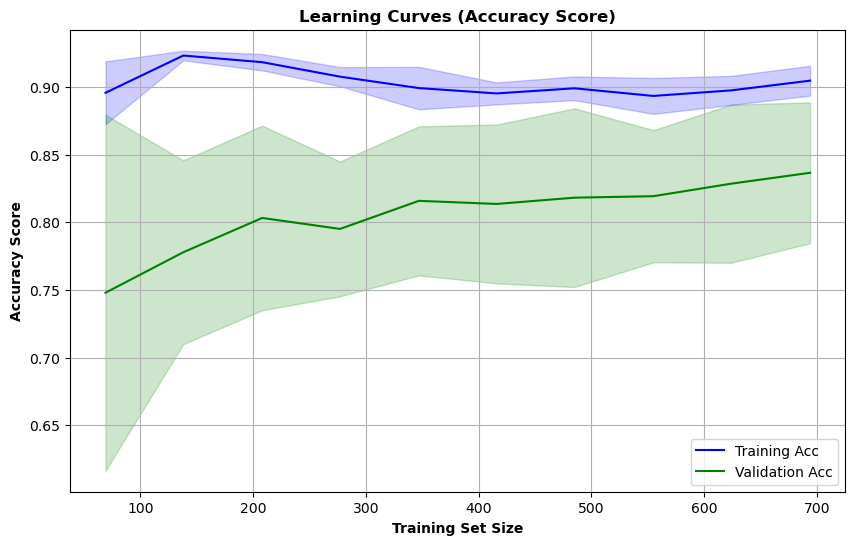

In [57]:
# Getting the learning curve data for the training and validation sets
train_sizes, train_scores, val_scores = learning_curve(final_classifier, x_train_trans, y_train_res, cv=5, scoring='accuracy', 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Acc', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Acc', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='green', alpha=0.2)

plt.title('Learning Curves (Accuracy Score)', weight='bold')
plt.xlabel('Training Set Size', weight='bold')
plt.ylabel('Accuracy Score', weight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('rf_learning_curve.png')
plt.show()

# Making predictions

In [58]:
# Features
# 'Age', 'SibSp', 'Fare', 'Pclass_1', 'Pclass_3', 'male', 'Embarked_s', 'is_alone', 'title_Miss', 'title_Mrs'

# Creating predictions
person_1 = np.array([20, 0, 50.0, 0, 1, 1, 1, 1, 0, 0])
person_2 = np.array([30, 1, 70.0, 1, 0, 0, 0, 0, 0, 1])
person_3 = np.array([60, 0, 100.0, 0, 0, 0, 1, 0, 1, 0])
person_4 = np.array([40, 2, 80.0, 1, 0, 1, 0, 0, 0, 0])

# Adding all the predictions into the same variable
titanic_pred = np.stack((person_1, person_2, person_3, person_4))

In [59]:
# Using the model to get the predictions
print(final_classifier.predict(titanic_pred))

# Using the model to get the probabilities for each outcome
print(final_classifier.predict_proba(titanic_pred))

[0 1 1 1]
[[0.78808892 0.21191108]
 [0.00677798 0.99322202]
 [0.15442214 0.84557786]
 [0.49331395 0.50668605]]
